<a href="https://colab.research.google.com/github/Loris997/Assignments-Loris-Widmer/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practical part (Assignment, June 14)**

Find any data set that can be used for a recommender system and try to train and validate a neural network for it.

For this purpose I ask you to download a data set from the given lists and to use it for your program application.

https://gist.github.com/entaroadun/1653794

https://github.com/caserec/Datasets-for-Recommender-Systems

https://grouplens.org/datasets/movielens/

https://eigentaste.berkeley.edu/dataset/


I choose the anime dataset where people rated anime "movies".

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')


drive.mount('/content/drive')
anime_data = pd.read_csv("/content/drive/My Drive/SE/anime.csv")
rating_data = pd.read_csv("/content/drive/My Drive/SE/rating.csv")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [81]:
print(f"Shape of the ratings data: {rating_data.shape}.")

Shape of the ratings data: (7813737, 3).


In [82]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [83]:
print(f"Shape of the ratings data: {anime_data.shape}.")

Shape of the ratings data: (12294, 7).


In [85]:
ratings = rating_data.merge(anime_data.loc[:, ['name', 'anime_id', 'type', 'episodes']], left_on='anime_id', right_on='anime_id')

In [86]:
print(f"Shape of the complete data: {ratings.shape}.")

Shape of the complete data: (7813727, 6).


In [87]:
ratings.head()

,user_id,anime_id,rating,name,type,episodes
0,1,20,-1,Naruto,TV,220
1,3,20,8,Naruto,TV,220
2,5,20,6,Naruto,TV,220
3,6,20,-1,Naruto,TV,220
4,10,20,-1,Naruto,TV,220


In [88]:
print(f"Number of unique users: {ratings['user_id'].unique().size}.")
print(f"Number of unique animes: {ratings['anime_id'].unique().size}.")

Number of unique users: 73515.
Number of unique animes: 11197.


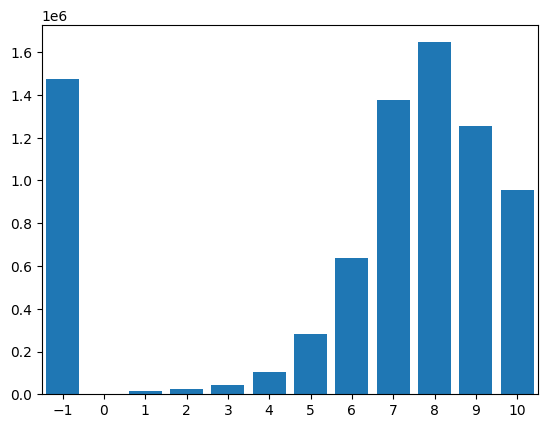

In [89]:
x, height = np.unique(ratings['rating'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(x, height, align='center')
ax.set(xticks=np.arange(-1, 11), xlim=[-1.5, 10.5])
plt.show()

To speed up the process a bit I removed the -1 ratings (these were people who watched something but did not give a rating). Further I looked at the most popular animes.

In [98]:
# Most popular movies
anime_data_5000 = anime_data.loc[(anime_data['popularity'] > 3500) ] # & (anime_data['type'] == 'TV')

# Remove movies with a rating of -1
ratings = ratings[(ratings['rating'] > -1) ] # & (ratings['user_id'] < 10000)

In [136]:
# Number of positive ratings by each user
user_popularity = ratings.loc[ratings["rating"]>=5].groupby('user_id').size().reset_index(name='user_popularity')

popular_users_list = user_popularity.loc[user_popularity["user_popularity"]>=15]['user_id']
print(len(popular_users_list),"# active users")

display(user_popularity)

47122 # active users


,user_id,user_popularity
0,3,64
1,5,111
2,7,153
3,11,68
4,12,20
...,...,...
50602,73507,125
50603,73510,67
50604,73511,10
50605,73513,26


I updated the ratings to only be the most popular ones.

In [139]:
ratings = ratings.loc[ratings["user_id"].isin(popular_users_list)]

I created the new column "new_anime_id". Then assigned numbers from 0 upwards(unique identifier).
Further was this identifier set as index of the dataframe.

In [140]:
anime_data_5000 = anime_data_5000.assign(new_anime_id=pd.Series(np.arange(anime_data_5000.shape[0])).values)
anime_data_5000_indexed = anime_data_5000.set_index('new_anime_id')

Merge the ratings and the subset anime_data_5000, and adding the new columns.

In [141]:
ratings = ratings.merge(anime_data_5000.loc[:, ['anime_id', 'new_anime_id', 'popularity']], left_on='anime_id', right_on='anime_id')

Creating a new dataset to assign new unique IDs to the users in the ratings dataframe.

In [142]:
user = pd.DataFrame({'user_id': np.unique(ratings['user_id'])})
user = user.assign(new_user_id=pd.Series(np.arange(user.shape[0])).values)

Merging the ratings and user data on user_id. So now the unique new_user_id column is in ratings.

In [143]:
ratings = ratings.merge(user, left_on='user_id', right_on='user_id')

In [109]:
ratings.head(5)

,user_id,anime_id,rating,name,type,episodes,new_anime_id,popularity,new_user_id
0,3,20,8,Naruto,TV,220,295,25925,0
1,3,8074,6,Highschool of the Dead,TV,12,444,23065,0
2,3,9919,8,Ao no Exorcist,TV,25,249,21204,0
3,3,11737,7,Ao no Exorcist Movie,Movie,1,265,4145,0
4,3,11757,9,Sword Art Online,TV,25,288,30583,0


Calculating the max users and animes.

In [153]:
MAX_USER_ID = ratings['user_id'].max()
MAX_ITEM_ID = ratings['anime_id'].max()

N_USERS = MAX_USER_ID + 1
N_ITEMS = MAX_ITEM_ID + 1

Split the data into training and test.

In [114]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

user_id_train = np.array(train['new_user_id'])
anime_id_train = np.array(train['new_anime_id'])
ratings_train = np.array(train['rating'])

user_id_test = np.array(test['new_user_id'])
anime_id_test = np.array(test['new_anime_id'])
ratings_test = np.array(test['rating'])

In [124]:
class RecommenderModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size):
        super(RecommenderModel, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_size, input_length=1)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_size, input_length=1)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_embed = self.flatten(self.user_embedding(inputs[0]))
        item_embed = self.flatten(self.item_embedding(inputs[1]))
        concat = tf.keras.layers.Concatenate()([user_embed, item_embed])
        dense1_out = self.dense1(concat)
        output = self.dense2(dense1_out)
        return output

Setting embedding_size and the RecommenderModel.

In [145]:
embedding_size = 32
model = RecommenderModel(N_USERS, N_ITEMS, embedding_size)

Compiling the model.

In [147]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
# Train the model

model.fit([user_id_train, anime_id_train], ratings_train, batch_size=64, epochs=5, validation_data=([user_id_test, anime_id_test], ratings_test))


Epoch 1/5
45284/45284 [==============================] - 950s 21ms/step - loss: 1.2982 - val_loss: 1.3063
Epoch 2/5
45284/45284 [==============================] - 972s 21ms/step - loss: 1.2466 - val_loss: 1.2813
Epoch 3/5
45284/45284 [==============================] - 941s 21ms/step - loss: 1.2004 - val_loss: 1.2791
Epoch 4/5
45284/45284 [==============================] - 959s 21ms/step - loss: 1.1520 - val_loss: 1.2671
Epoch 5/5
45284/45284 [==============================] - 989s 22ms/step - loss: 1.1060 - val_loss: 1.2573


Generating recomendations for the user with the id 15.

In [146]:
user_id = 15
item_ids = np.arange(N_ITEMS)
user_ids = np.full_like(item_ids, user_id)
predictions = model.predict([user_ids, item_ids])

item_predictions = {item_id: prediction for item_id, prediction in zip(item_ids, predictions)}
sorted_items = sorted(item_predictions.items(), key=lambda x: x[1], reverse=True)
for item_id, prediction in sorted_items:
    print(f"Item ID: {item_id}, Predicted Value: {prediction}")


19/19 [==============================] - 0s 1ms/step
Item ID: 186, Predicted Value: [0.03894001]
Item ID: 502, Predicted Value: [0.03271471]
Item ID: 461, Predicted Value: [0.030937]
Item ID: 284, Predicted Value: [0.02096315]
Item ID: 159, Predicted Value: [0.02051638]
Item ID: 357, Predicted Value: [0.01900135]
Item ID: 4, Predicted Value: [0.01734125]
Item ID: 154, Predicted Value: [0.0141208]
Item ID: 400, Predicted Value: [0.01357457]
Item ID: 136, Predicted Value: [0.01243631]
Item ID: 286, Predicted Value: [0.0123352]
Item ID: 238, Predicted Value: [0.01219276]
Item ID: 104, Predicted Value: [0.01210077]
Item ID: 523, Predicted Value: [0.01190867]
Item ID: 540, Predicted Value: [0.01094717]
Item ID: 572, Predicted Value: [0.01091951]
Item ID: 25, Predicted Value: [0.01066846]
Item ID: 201, Predicted Value: [0.01066178]
Item ID: 546, Predicted Value: [0.01066177]
Item ID: 512, Predicted Value: [0.01059991]
Item ID: 375, Predicted Value: [0.01029698]
Item ID: 566, Predicted Value:

Calculating the Test loss.

In [135]:
test_loss = model.evaluate([user_id_test, anime_id_test], ratings_test)
print("Test Loss:", test_loss)

22642/22642 [==============================] - 37s 2ms/step - loss: 1.2573
Test Loss: 1.2572669982910156
